In [8]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
# from IPython.display import Image
import graphviz
from sklearn.preprocessing import Imputer
from io import StringIO
from sklearn.metrics import confusion_matrix

In [2]:
# Read in the data and split each part into X (predictors) and y (target value)
df_test = pd.read_csv('internetads_test.csv', encoding='gbk', na_values=['?'])
df_train = pd.read_csv('internetads_train.csv', encoding='gbk', na_values=['?'])
predictors = list(df_test)  # list of all feature names
respond_val = predictors.pop()  # target name: class

X_train = df_train.loc[:, predictors]
y_train = df_train[respond_val]
X_test = df_test.loc[:, predictors]
y_test = df_test[respond_val]

In [3]:
# Part-I: Preprocessing, data cleaning
def isInt(series):  # take a column as input, known its dtype as int or float
    for entry in series:
        try:  # try to convert each entry into integer
            _ = int(entry)
        except ValueError:  # once cannot be done, the entry may be missing value or the whole column is float type
            if not entry.strip() == '?':
                return False
    return True


def clean_type_by_col(df):  # replace each '?' with NaN for convenience of applying Imputer
    nan = float('NaN')
    for col in predictors:
        if df[col].dtypes == 'object':  # contains str type, caused by any '?' in this column
            if isInt(df[col]):
                df[col] = [int(d) if d.strip() != '?' else nan for d in df[col]]
            else:
                df[col] = [float(d) if d.strip() != '?' else nan for d in df[col]]

clean_type_by_col(X_train)
clean_type_by_col(X_test)

In [4]:
# Part-I Cont.
# Substitute missing value with mode value of the column
# because the number of missing entries in each column is not ignorable
imp = Imputer(strategy='most_frequent', axis=0)  # by column
X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

In [14]:
# Part-II: Tree Fitting and Plotting

def plot_tree(clf, plot_name):  # Structural figures exported into the working directory as pdf
    dot_data = StringIO()
    export_graphviz(clf, out_file=dot_data, feature_names=predictors, 
                    class_names=['ad.', 'nonad.'], filled=True, 
                    rounded=True, special_characters=True)
    graphviz.Source(dot_data.getvalue()).render(plot_name, view=False)

for max_depth in (5, 3):
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_train, y_train)
    plot_tree(tree, 'depth_{:d}_tree'.format(max_depth))
    y_pred = tree.predict(X_test)
    error_rate = sum(y_pred != y_test) / len(y_test)
    print('Tree max_depth={:d}, error rate={:.3f}'.format(max_depth, error_rate))
    

#     For max_depth=3 case, 
#         the 1st level feature used for classification is 'desturl_com', 
#         2nd level contains 'url_ads' and 'desturl_readersndex',
#         3rd level contains 'desturl_click', 'width' and 'origurl_tripod_com';
#     Rules are like to be: figuring out those urls that has credible signatures, while filtering out infamous ad sites.
    
#     For max_depth=5 case,
#         most of the upper level structure (nodes) changed little, affirming the principles of rules stated above;
#         while at lower level more detailed pattern from urls are added to help, e.g. whether from developed countries,
#         or the size of the pictures.
    
#     As the max_depth increased from 3 to 5, the classification performance upgrades, error rate went down.


Tree max_depth=5, error rate=0.053
Tree max_depth=3, error rate=0.062


[[ 74  44]
 [  3 658]]


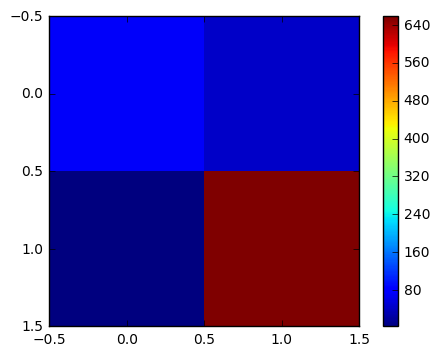

In [12]:
# Part-II Cont.   Confusion Matrix for max_depth = 3
def plot_conf_mat(matrix): 
    fig = plt.figure()
    plt.clf()
    ax = fig.add_subplot(111)
    ax.set_aspect(1)
    grid = plt.imshow(matrix, interpolation='nearest')
    cb = fig.colorbar(grid)
    plt.show()
    
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(conf_mat)
plot_conf_mat(conf_mat)

In [15]:
# Part-III: Random Forest
forest = RandomForestClassifier(n_estimators=50, oob_score=True)
forest.fit(X_train, y_train)
error_rate = sum(forest.predict(X_test) != y_test) / len(y_test)
print('Random Forest out-of-bag error-rate={:.3f}, test error-rate={:.3f}'
      .format(1 - forest.oob_score_, error_rate))

# Difference between OOB & Error-rate:
#     The bagging-based ensemble model, random forest, is trained using bootstrap aggregation, 
#     where each new tree is fit from a bootstrap sample of the training observations z_i = (x_i, y_i). 
#     The out-of-bag (OOB) error is the average error for each z_i calculated using predictions from the trees 
#     that do not contain z_i in their respective bootstrap sample.
#     This allows the RandomForestClassifier to be fit and validated whilst being trained.
#
#     On the contrary, error-rate are usually generated after training, when applying model to unseen test data;
#     it measures the capability of the model to generalization, rather than fitting a priori (as OOB does).

Random Forest out-of-bag error-rate=0.021, test error-rate=0.023


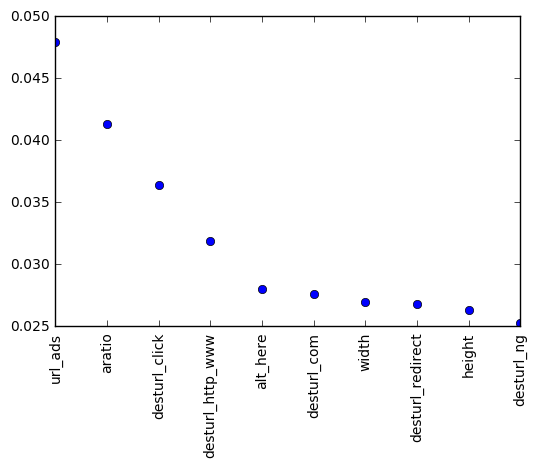

In [7]:
top10_features = sorted(zip(forest.feature_importances_, predictors), reverse=True)[:10]
scores, features = zip(*top10_features)
plt.figure()
# plt.xticks(range(1, 11), features)
fig, ax = plt.subplots()
ax.set_xticks(range(1, 11))
ax.set_xticklabels(features, rotation=90)

plt.plot(range(1, 11), list(scores), 'o')
plt.show()

# The preferred features given by random forests are much different from that of generated by single trees,
# although most significant predictors such as 'desturl_com', 'width', 'url_ads' etc. still counts,
# their rank change, while more other features are given chance to show up ('alt_here', 'desturl_ng', e.g.).